<a href="https://colab.research.google.com/github/dnzambuli/Deep-learning-4-CV/blob/master/Unsupervised_Learning_in_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
This assignment aims to assess your ability to apply unsupervised learning techniques in computer vision. You will work with an image dataset and implement different methods to extract meaningful representations, analyze patterns, and evaluate model performance.

## Expected Learning Outcomes
By completing this assignment, you will:

✅ Understand the application of unsupervised learning in computer vision.

✅ Develop hands-on experience in clustering, dimensionality reduction, and contrastive learning.

✅ Analyze and compare different representation learning techniques.

✅ Enhance your ability to work with image datasets in machine learning pipelines.

# Instructions
* Use **Python** and frameworks such as **NumPy**, **scikit-learn**, **PyTorch**, and **OpenCV**.

* Write clean, well-commented code.
* Submit a **Jupyter Notebook/Python script** with a short report explaining your methodology, results, and observations.
* Include visualizations wherever necessary.

In [1]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# read and extract to the local session the content from /content/drive/MyDrive/DL4CV

from google.colab import drive
import os
import matplotlib.pyplot as plt
import shutil
import zipfile

# Define the source directory containing the zip files
source_dir = '/content/drive/MyDrive/DL4CV'

# Define the destination directory to extract the zip files
destination_dir = '/content/'
if not os.path.exists(destination_dir):
  os.makedirs(destination_dir)

# Iterate through the files in the source directory
for filename in os.listdir(source_dir):
  source_file = os.path.join(source_dir, filename)

  # Check if the file is a zip file
  if filename.endswith('.zip'):
    print(f"Extracting {filename}...")

    # Extract the zip file to the destination directory
    with zipfile.ZipFile(source_file, 'r') as zip_ref:
      zip_ref.extractall(destination_dir)

    print(f"Extraction completed for {filename}.")


Extracting Road Crack Detection-Combined Dataset.zip...
Extraction completed for Road Crack Detection-Combined Dataset.zip.
Extracting Road cracks.zip...
Extraction completed for Road cracks.zip.


In [3]:
# COUNT THE FILES IN ROAD CRACKS FOLDER AND TRAIN FOLDER
def count_files_in_folder(folder_path):
  """Counts the number of files in a given folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    The number of files in the folder.
  """
  if not os.path.exists(folder_path):
    return 0
  count = 0
  for _, _, files in os.walk(folder_path):
    count += len(files)
  return count


road_cracks_folder = '/content/Road cracks'
train_folder = '/content/train'

num_road_cracks_files = count_files_in_folder(road_cracks_folder)
num_train_files = count_files_in_folder(train_folder)

print(f"Number of files in road_cracks folder: {num_road_cracks_files}")
print(f"Number of files in train folder: {num_train_files}")


Number of files in road_cracks folder: 125
Number of files in train folder: 1389


In [4]:
# check which files are in Road cracks and repeated in train

def find_common_files(folder1, folder2):
  """Finds files that are present in both folders.

  Args:
    folder1: The path to the first folder.
    folder2: The path to the second folder.

  Returns:
    A list of file names that are present in both folders.
  """
  files1 = set(os.listdir(folder1))
  files2 = set(os.listdir(folder2))
  common_files = files1.intersection(files2)
  return list(common_files)


road_cracks_folder = '/content/train'
train_folder = '/content/Road cracks'

common_files = find_common_files(road_cracks_folder, train_folder)

print("Files present in both 'Road cracks' and 'train' folders:")
for file in common_files:
  print(file)


Files present in both 'Road cracks' and 'train' folders:


# Task 1: Image Data Preprocessing

Perform necessary data preprocessing:
1. Convert images to grayscale (if required).
2. Normalize pixel values.
3. Apply data augmentation techniques (e.g., flipping, rotation)

## Deliverables:
* Code implementation
* Short explanation of preprocessing steps

In [5]:
import cv2
import numpy as np
import os
import random

# Data Preprocessing Implementation
## 1. Loading and Normalizing Images
### Steps:
1. **Extract Images and Filenames**
- Load images from their respective directories along with their filenames.

> *Why?*
>
>This ensures proper tracking of images and their labels (if filenames contain metadata).

2. **Convert Images to Grayscale**

- Transform RGB/BGR images into single-channel grayscale.

> *Why?*
>
> Reduces computational complexity (1 channel instead of 3).
>
> Since crack detection relies on structural patterns rather than color, grayscale preserves necessary features while simplifying the model.

3. **Resize Images to (128×128) and Normalize**

- Resize all images to a fixed dimension (128×128).

- Normalize pixel values (e.g., scale to [0, 1] or standardize using mean/std).

> *Why?*
>
>Ensures uniform input size for neural networks.
>
> Normalization helps models converge faster by keeping gradients stable.

4. Add Channel Dimension for Grayscale

- Reshape images from (128, 128) to (128, 128, 1).

> *Why?*
>
> Deep learning frameworks (TensorFlow/PyTorch) expect explicit channel dimensions, even for grayscale.

5. **Return Images with Filenames**

- Maintain a mapping between processed images and their original filenames for traceability.

## 2. Data Augmentation
### Steps:
1. **Apply Random Transformations**

- Random horizontal/vertical flips.

- Rotations (90°, 180°, 270°).

> *Why?*
>
> Increases dataset diversity artificially.
>
> Helps prevent overfitting by exposing the model to more variations (e.g., cracks at different orientations).

2. **Combine Augmented Data into Unified Arrays**

- Merge original and augmented images into a single NumPy array (X).

- Store corresponding labels in another array (y).

> *Why?*
>
> Streamlines training by providing a single, shuffled dataset.
>

## 3. Convert Images to .keras Format

> Why?
>
> **Efficiency:** .keras (or .tfrecord) is optimized for TensorFlow/PyTorch, enabling faster I/O during training.
>
> **Portability:** Serializes data + metadata (labels, normalization stats) in a standardized format.
>
> **Reproducibility:** Ensures consistent preprocessing across experiments.

## 4. Data Splitting
### Steps:
> - Split `content/train` (1,389 images) into 80% Train / 20% Validation
>
> *Why?*
>
> **Training set:** Used to train the model.
>
> **Validation set:** Monitors model performance during training (e.g., tuning hyperparameters, detecting overfitting).



> - Use `content/Road Cracks` (125 images) as Test Set
>
> *Why?*
>
> Provides an unseen dataset to evaluate final model generalization.
>
> Ensures unbiased performance metrics (avoids data leakage from train/val sets).

In [14]:
import tensorflow as tf
import random

def load_and_normalize_images(folder_path = train_folder, image_size = (128, 128)):
  """
  Loads .jpg images from the folder
    converts some to greyscale images
  resizes the images, normalizes the pixels to [0,1]

  returns:
    images (numpy array): Array of preprocessed images

    filenames: lists the corresponding filenames
  """
  images = []
  filenames = []

  for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
      img_path = os.path.join(folder_path, filename)

      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #convert to greyscale
      img = cv2.resize(img, image_size)  # Resize to fixed size
      img = img /255.0 # normalize to [0,1]

      images.append(img)

      filenames.append(filename)

  images = np.array(images).astype("float32") # get a np arrray object
  images = np.expand_dims(images, axis = -1) # add channel information

  return images, filenames

def ensure_shape(image, target_size=(128, 128)):
    if len(image.shape) == 2:  # Convert grayscale images to (H, W, 1)
        image = np.expand_dims(image, axis=-1)
    return image

def augment_image(image, filename, target_size = (128, 128)):
  """
  applies data augmentation techniques (flipping, rotating) on images
  and ensures all outputs are (128, 128)

  args:
    images (np array): a single greyscale image
    filename (str): The original filename.
    target_size (tuple): Desired output shape (default: 128x128).

  returns:
    augmented_images (list): list of augmented images
    augmented_labels (list): Corresponding labels.
  """
  augmented_images = [image] # the original image is added to begin the list
  augmented_labels = [filename] # the image lables

  # ---- Flipping Images ----
  # horizontal flip
  if random.choice([True, False]):
    flipped = cv2.flip(image, 1)
    flipped = ensure_shape(cv2.resize(flipped, target_size))
    augmented_images.append(flipped)
    augmented_labels.append(filename + "_flipH")

  # vertical flip
  if random.choice([True, False]):
    flipped = cv2.flip(image, 0)
    flipped = ensure_shape(cv2.resize(flipped, target_size))
    augmented_images.append(flipped)
    augmented_labels.append(filename + "_flipV")

  # ---- Rotating Images ----

  # random rotation
  rotation_choice = random.choice([0, 90, 180, 270])
  if rotation_choice != 0:  # Skip if no rotation
        if rotation_choice == 90:
            rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        elif rotation_choice == 180:
            rotated = cv2.rotate(image, cv2.ROTATE_180)
        elif rotation_choice == 270:
            rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        rotated = ensure_shape(cv2.resize(rotated, target_size))  # Force resize
        augmented_images.append(rotated)
        augmented_labels.append(filename + f"_rot{rotation_choice}")

  return augmented_images, augmented_labels

def augment_dataset(images, filenames, target_size =(128, 128)):
  """
    Applies random augmentation to the entire dataset.

    Args:
        images (list of numpy arrays): Original images.
        filenames (list): Corresponding filenames.

    Returns:
        all_images (numpy array): Combined original & augmented images.
  """
  augmented_images = []
  augmented_labels = []

  for img, fname in zip(images, filenames):
    aug_imgs, aug_labels = augment_image(img, fname, target_size)
    augmented_images.extend(aug_imgs)
    augmented_labels.extend(aug_labels)

  return np.array(augmented_images, dtype="float32"), np.array(augmented_labels, dtype = "object")


def convert_to_keras_dataset(images, labels, save_path = "content/train.keras"):
  """
  converts a numpy array into a tensorflow object and saves it as a .keras file

  Args:
    image (numpy array): aArray of processed images
    labels (numpy array): Array of labels.
    save_path (str): path to save the .keras dataset
  """
  # Convert images and labels to tensors
  images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
  labels_tensor = tf.convert_to_tensor(labels, dtype=tf.string)

  # Create a dataset from tensors
  dataset = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))

  # Create a SavedModel signature
  @tf.function(input_signature=[dataset.element_spec])
  def serve_example(element):
      return {"image": element[0], "label": element[1]}

  signatures = {"serving_default": serve_example}

  # Save the dataset as a SavedModel
  tf.saved_model.save(dataset, save_path, signatures=signatures)

  print(f"Dataset saved to {save_path}")


# Following this Error

```bash
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-12-ab93e3430d7f> in <cell line: 0>()
      1 images, filenames = load_and_normalize_images()  # Load images
----> 2 augmented_images = augment_dataset(images, filenames)  # Augment dataset
      3
      4 # split to 80:20 training:validation dataset
      5 train_images, val_images, train_labels, val_labels = train_test_split(

<ipython-input-11-4664164b5ce8> in augment_dataset(images, filenames)
     91     augmented_labels.extend(aug_labels)
     92
---> 93   return np.array(augmented_images).astype("float32"), np.array(augmented_labels)
     94
     95

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (354, 128, 128) + inhomogeneous part.
```

I need to `resize` augmented images. *why?*

## 1. Guaranteed Consistency

- Every augmented image (flipped/rotated) is resized to (128, 128) immediately after transformation.

- Eliminates shape mismatches (e.g., `90° rotations` that `swap width/height`).

## 2. Normalization

If your input images are already normalized (e.g., pixel values in [0, 1]), resizing with cv2.resize preserves this (uses linear interpolation by default).

## 3. Debugging-Friendly

- No more ValueError from inhomogeneous shapes.

**Confirming** Use print(image.shape) inside augment_image() to verify all outputs are (128, 128).

how to confirm:
```python
# Load original images (assumed to be 128x128)
images, filenames = load_and_normalize_images()  

# Augment (outputs will all be 128x128)
aug_images, aug_labels = augment_dataset(images, filenames)  

# Verify shapes
print("Augmented images shape:", aug_images.shape)  # Expected: (N, 128, 128)
print("Sample label:", aug_labels[0])  # e.g., "crack_001.jpg_flipH"
```

# Why This Works
1. cv2.resize() `Overrides All Shapes`: Even if a rotation/flip temporarily changes dimensions, resizing forces them back to (128, 128).

2. Efficiency: Resizing is fast and happens on-the-fly during augmentation.

3. Compatibility: Works seamlessly with train_test_split() or PyTorch/TensorFlow pipelines.

In [15]:
from sklearn.model_selection import train_test_split

images, filenames = load_and_normalize_images()  # Load images
augmented_images, augmented_labels = augment_dataset(images, filenames)  # Augment dataset

# split to 80:20 training:validation dataset
train_images, val_images, train_labels, val_labels = train_test_split(
    augmented_images, augmented_labels, test_size=0.2, random_state=42
)

# Save both train and validation datasets
convert_to_keras_dataset(train_images, train_labels, "train_road_cracks.keras")
convert_to_keras_dataset(val_images, val_labels, "val_road_cracks.keras")

# the test data will be the road_cracks data as no data repeats
test_images, test_labels = load_and_normalize_images(folder_path = road_cracks_folder)
convert_to_keras_dataset(test_images, test_labels, "test_road_cracks.keras")

Dataset saved to train_road_cracks.keras
Dataset saved to val_road_cracks.keras
Dataset saved to test_road_cracks.keras



```bash
WARNING:tensorflow:From <ipython-input-8-893057829cf5>:122: save (from tensorflow.python.data.experimental.ops.io) is deprecated and will be removed in a future version.
Instructions for updating:
```

This warning arises because you are using a deprecated function tf.data.experimental.save to save the dataset in the .keras format.

Here's how you can fix it using the updated approach with tf.saved_model:

**Convert from**
```python
def convert_to_keras_dataset(images, labels, save_path = "content/train.keras"):
  """
  converts a numpy array into a tensorflow object and saves it as a .keras file

  Args:
    image (numpy array): aArray of processed images
    labels (numpy array): Array of labels.
    save_path (str): path to save the .keras dataset
  """
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))
  tf.data.experimental.save(dataset, save_path)
  print(f"Dataset saved to {save_path}")
```

**To:**

```python
def convert_to_keras_dataset(images, labels, save_path = "content/train.keras"):
  """
  converts a numpy array into a tensorflow object and saves it as a .keras file

  Args:
    image (numpy array): aArray of processed images
    labels (numpy array): Array of labels.
    save_path (str): path to save the .keras dataset
  """
  def generator():
      for image, label in zip(images, labels):
          yield image, label

  dataset = tf.data.Dataset.from_generator(
      generator,
      output_signature=(
          tf.TensorSpec(shape=images[0].shape, dtype=images[0].dtype),
          tf.TensorSpec(shape=(), dtype=tf.string),  # Assuming labels are strings
      ),
  )

  # Create a SavedModel signature
  @tf.function(input_signature=[dataset.element_spec])
  def serve_example(element):
      return {"image": element[0], "label": element[1]}

  signatures = {"serving_default": serve_example}

  tf.saved_model.save(dataset, save_path, signatures=signatures)

  print(f"Dataset saved to {save_path}")

```

# Task 2: Clustering for Image Categorization

1. Extract features from images using **Histogram of Oriented Gradients (HOG)**, **ORB**, or
**deep features from a pretrained CNN**.
2. Apply **K-Means** and **DBSCAN** clustering to group similar images.
3. Use the Silhouette Score to evaluate clustering quality.

## Deliverables:
* Code for feature extraction and clustering
* Visualization of clusters (e.g., sample images from each cluster)
* Evaluation and interpretation of results

# Feature Extraction & Clustering for Road Crack Detection
## 1. Loading the Test Dataset
**Input:** Preprocessed .keras file (test_road_cracks.keras).

*Why?* Avoids reloading images from folders—data is already normalized and formatted for ML.

Example:

```python
import tensorflow as tf
test_data = tf.keras.models.load_model("test_road_cracks.keras")  # Load serialized dataset
images = test_data["images"]  # Extract images
labels = test_data["labels"]  # Optional, if available
```

## 2. Feature Extraction
### a. HOG (Histogram of Oriented Gradients)

- **What it does:** Captures texture/shape by analyzing gradient directions in image patches.

- *Why use it?* Effective for crack detection (cracks have strong edges).

- **Example Output:** A feature vector (e.g., `[0.2, 1.7, ...]` length=144).

Code Example:

```python
from skimage.feature import hog
hog_features = [hog(img, orientations=9, pixels_per_cell=(8,8)) for img in images]
```

### b. ORB (Oriented FAST and Rotated BRIEF)
- **What it does:** Detects keypoints (corners/blobs) and describes them with binary features.

- *Why use it?* Fast and rotation-invariant (good for cracks at different angles).

- **Example Output:** Keypoints + descriptors (e.g., `(x,y) coordinates + binary codes`).

Code Example:

```python
import cv2
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(img, None)  # For each image
```

### c. Deep Features (MobileNetV2 CNN)
- **What it does:** Uses a pre-trained CNN to extract high-level features.

- *Why use it?* Captures complex patterns (e.g., subtle cracks) better than handcrafted methods.

- **Example Output:** A `1280-dimensional vector` per image.

Code Example:

```python

from tensorflow.keras.applications import MobileNetV2
model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")
deep_features = model.predict(images)
```

## 3. Clustering Techniques
### a. K-Means
- **What it does:** Groups images into n_clusters based on feature similarity.

- *Why use it?* Simple and fast for well-separated clusters (e.g., `distinct crack types`).

> Example:
>
> Input: HOG features (shape=[num_images, 144]).
>
> Output: Labels like `[0, 1, 0, 2, ...]` for each cluster.
>

Code Example:

```python
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(hog_features)
clusters = kmeans.labels_
```

### b. DBSCAN
- **What it does:** Groups images based on density (no fixed cluster count).

- *Why use it?* Handles outliers/noise (e.g., `misclassified cracks`).

> Example:
>
> Input: ORB descriptors (after flattening).
>
> Output: Labels like `[0, -1, 1, ...] (-1 = noise)`.

Code Example:

```python

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(orb_descriptors)
```

### c. Silhouette Score
- **What it does:** Measures how well clusters are separated (range: `[-1, 1]`).

- *Why use it?* Evaluates clustering quality (higher = better).

Example Output: `0.65 (good)`, `-0.1 (poor)`.

Code Example:

```python
from sklearn.metrics import silhouette_score
score = silhouette_score(features, clusters)
```
## 4. Visualization
- **Goal:** Show `5 sample images per cluster` to inspect crack categories.

- *Why?* Validates if clusters make sense (e.g., `"severe cracks"` vs. `"hairline cracks"`).

> Example Output:
>
> Cluster 0: 5 images of wide cracks.
>
> Cluster 1: 5 images of linear cracks.

Code Example:

```python
import matplotlib.pyplot as plt
for cluster_id in range(3):
    cluster_samples = images[clusters == cluster_id][:5]  # Get 5 samples
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(cluster_samples):
        plt.subplot(1, 5, i+1)
        plt.imshow(img, cmap="gray")
    plt.title(f"Cluster {cluster_id}")
```

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from skimage.feature import hog

In [41]:
# use functions to write DRY code
# Load dataset from .keras file
def load_keras_dataset(file_path="test_road_cracks.keras"):
  '''
  Reads the .keras file

  Args:
    file_path : the path to the test data because its small enough to run
    clustering
  Output:
    images (numpy array): Array of preprocessed images
    filenames: lists the corresponding filenames
  '''
  # Load the dataset from the .keras file
  dataset = tf.data.experimental.load(file_path)

  # Extract images and labels
  images = []
  filenames = []

  for image, label in dataset:
      images.append(image.numpy())  # Convert tensor to NumPy
      filenames.append(label.numpy().decode("utf-8"))  # Decode filename from bytes

  # Convert list to numpy array
  images = np.array(images, dtype=np.float32)

  return images, filenames

def extract_hog_features(images):
    """
    Extracts HOG features from images.

    Args:
        images (numpy array): Array of preprocessed images.

    Returns:
        hog_features (numpy array): Array of HOG features.
    """
    hog_features = []
    for img in images:
        img = img.squeeze()  # Remove channel dim
        feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(feature)
    return np.array(hog_features)

def extract_deep_features(images):
    """
    Extracts deep features from images using MobileNetV2.

    Args:
        images (numpy array): Array of preprocessed images.

    Returns:
        deep_features (numpy array): Array of deep features.
    """
    model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(128, 128, 3))
    images_rgb = np.stack([cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2RGB) for img in images])  # Convert grayscale to RGB
    images_preprocessed = preprocess_input(images_rgb)
    deep_features = model.predict(images_preprocessed)
    return deep_features

def extract_orb_features(images, max_features = 1000):
    """
    Extracts ORB features from images.

    Args:
        images (numpy array): Array of preprocessed images.

    Returns:
        orb_features (numpy array): Array of ORB features.
    """
    orb = cv2.ORB_create()
    orb_features = []

    for img in images:
        # Convert grayscale image to 3-channel BGR (ORB expects 3-channel images)
        if len(img.shape) == 2 or img.shape[-1] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Compute ORB features
        keypoints, descriptors = orb.detectAndCompute(img, None)

        if descriptors is not None:
            # Flatten descriptors and ensure a fixed size
            descriptors = descriptors.flatten()
            if descriptors.shape[0] < max_features:
                # Pad with zeros if fewer descriptors
                descriptors = np.pad(descriptors, (0, max_features - descriptors.shape[0]))
            else:
                # Truncate if there are more than max_features
                descriptors = descriptors[:max_features]
        else:
            # No descriptors found, use a zero vector
            descriptors = np.zeros(max_features)

        orb_features.append(descriptors)

    return np.array(orb_features, dtype=np.float32)

def apply_clustering(features, method="kmeans", eps=0.5, min_samples=5, n_clusters=5):
    """
    Applies clustering to the given features.

    Args:
        features (numpy array): Array of features.
        method (str): Clustering method ("kmeans" or "dbscan").
        eps (float): DBSCAN parameter (for DBSCAN).
        min_samples (int): DBSCAN parameter (for DBSCAN).
        n_clusters (int): Number of clusters (for KMeans).

    Returns:
        cluster_labels (numpy array): Array of cluster labels.
    """
    if method == "kmeans":
        clustering_model = KMeans(n_clusters=n_clusters, random_state=42)
    elif method == "dbscan":
        clustering_model = DBSCAN(eps=eps, min_samples=min_samples)

    cluster_labels = clustering_model.fit_predict(features)

    # Compute silhouette score
    silhouette_avg = silhouette_score(features, cluster_labels) if len(set(cluster_labels)) > 1 else -1
    print(f"Silhouette Score for {method}: {silhouette_avg:.4f}")

    return cluster_labels

def visualize_clusters(images, labels, filenames, n_clusters=5):
    """
    Visualizes clusters by showing 5 sample images from each cluster.

    Args:
        images (numpy array): Array of images.
        labels (numpy array): Array of cluster labels.

    Returns:
        None
    """
    unique_labels = np.unique(labels)

    # Ensure images are at least 3D (N, H, W) or 4D (N, H, W, C)
    images = np.array(images)
    if images.ndim == 3:  # If missing channel dimension, add it
        images = np.expand_dims(images, axis=-1)
    elif images.ndim == 1:  # If 1D, there's an issue with input data
        raise ValueError("Error: Images array is 1-dimensional, which is incorrect. Check the dataset loading process.")


    fig, axes = plt.subplots(len(unique_labels), 5, figsize=(10, len(unique_labels) * 2))

    for i, label in enumerate(unique_labels):
        indices = np.where(labels == label)[0][:5]  # Pick first 5 images from each cluster
        for j, idx in enumerate(indices):
          if len(unique_labels) > 1:
              axes[i, j].imshow(images[idx].squeeze(), cmap="gray")
              axes[i, j].set_title(f"Cluster {label}\n{filenames[idx]}")
              axes[i, j].axis("off")
          else:  # Case when there's only one cluster
              axes[j].imshow(images[idx].squeeze(), cmap="gray")
              axes[j].set_title(f"Cluster {label}\n{filenames[idx]}")
              axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# 1. HOG Features

In [25]:
test_images, test_filenames = load_keras_dataset("test_road_cracks.keras")
hog_features = extract_hog_features(test_images) #_deep_features for deep features
#_orb_features for ORB features

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


# 2. Clustering

In [26]:
# Apply Clustering
kmeans_labels = apply_clustering(hog_features, method="kmeans", n_clusters=5)
dbscan_labels = apply_clustering(hog_features, method="dbscan", eps=0.5, min_samples=5)

Silhouette Score for kmeans: 0.0043
Silhouette Score for dbscan: -1.0000


# Compare other models

In [35]:
deep_features = extract_deep_features(test_images)
kmeans_labels_deep = apply_clustering(deep_features, method="kmeans", n_clusters=5)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 632ms/step
Silhouette Score for kmeans: 0.2469


In [43]:
dbscan_labels_deep = apply_clustering(deep_features, method="dbscan", eps=0.5, min_samples=5)

Silhouette Score for dbscan: 0.5706


In [42]:
orb_features = extract_orb_features(test_images)
kmeans_labels_orb = apply_clustering(orb_features, method="kmeans", n_clusters=5)

Silhouette Score for kmeans: 0.6041


In [44]:
dbscan_labels_orb = apply_clustering(orb_features, method="dbscan", eps=0.5, min_samples=5)

Silhouette Score for dbscan: 0.4981


Based on the models, the Silhoette scores are

|Feature extraction Technique| Kmeans Score|dbScan Score
|:----|:----:|:----:|
|HOG|0.0043|-1|
|deep Features|0.2469|0.5706|
|ORB|0.6041|0.4981|

This means that `Oriented FAST and Rotated BRIEF`(ORB) has the best performance for `kmeans clustering` techniqes  

`deep features` are the best for `db Scan clustering` techniques

# 3. Visualize

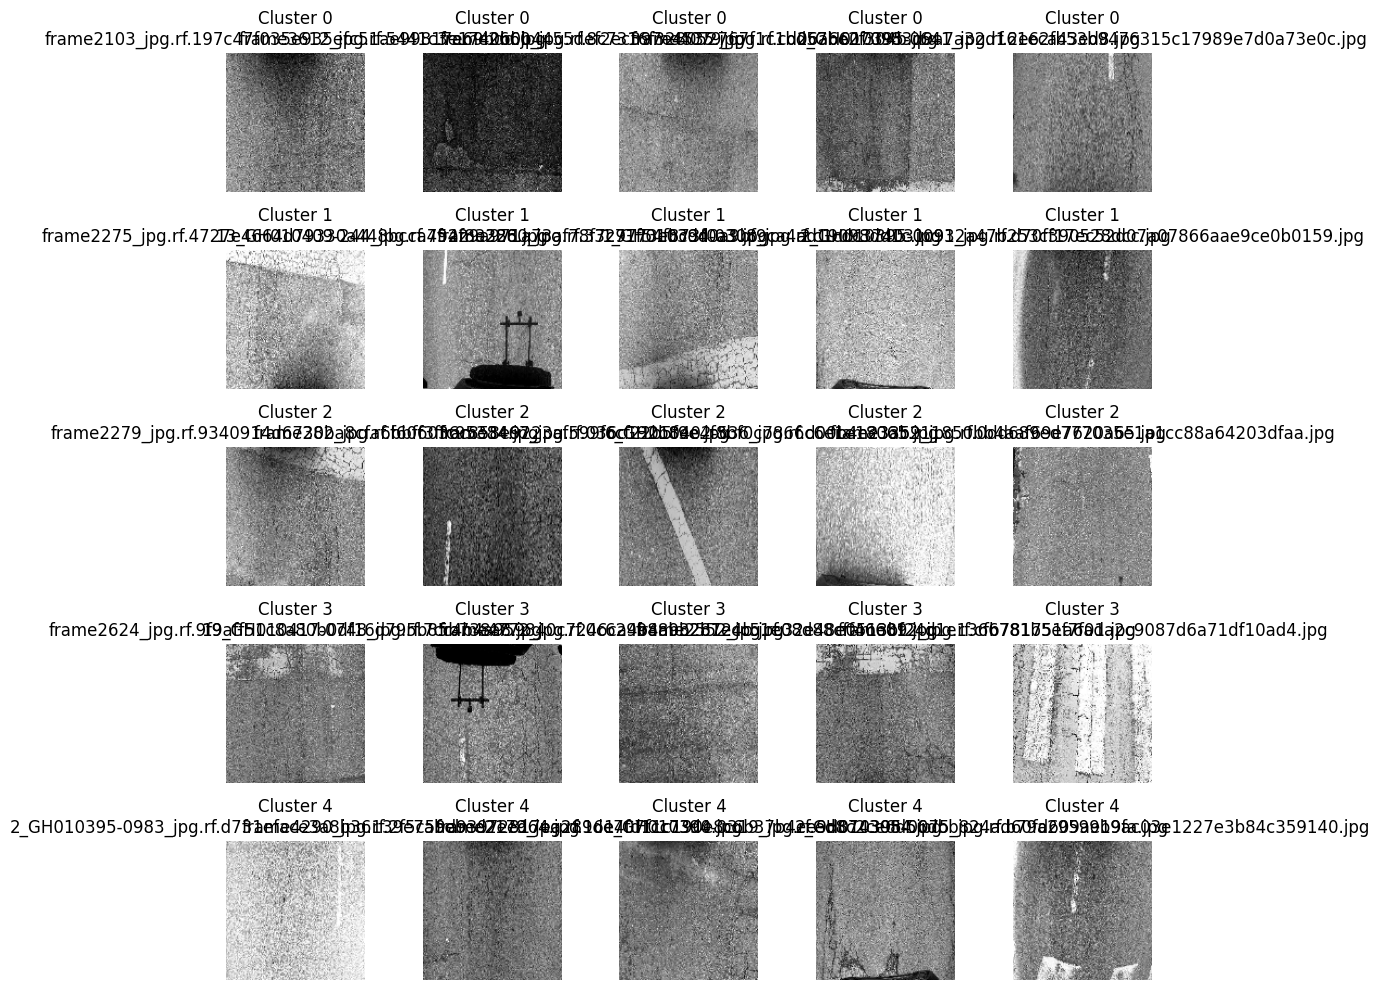

In [47]:
# Visualize Clusters
visualize_clusters(test_images, kmeans_labels_orb, test_filenames, n_clusters=5)

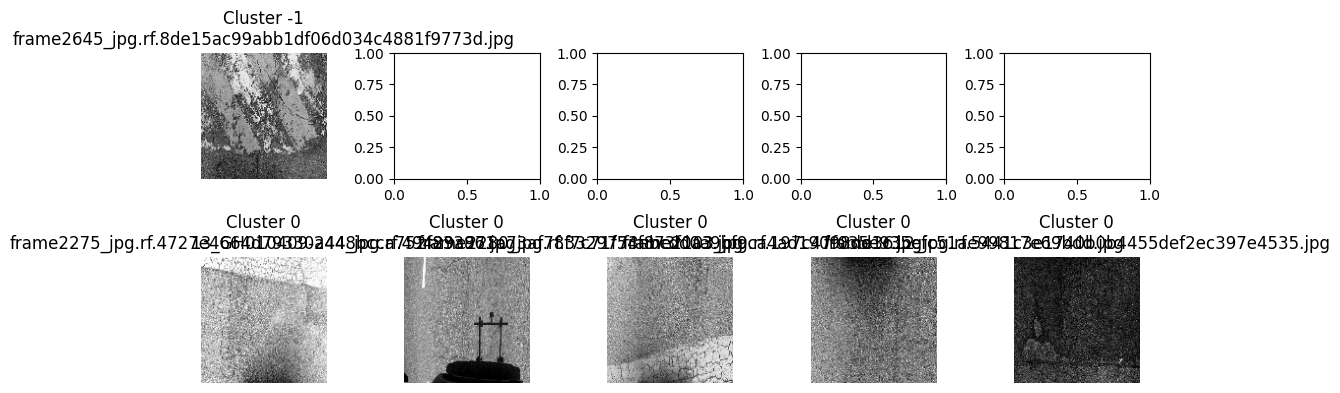

In [48]:
visualize_clusters(test_images, dbscan_labels_deep, test_filenames, n_clusters=5)

# Task 3: Dimensionality Reduction and Visualization

1. Apply Principal Component Analysis (PCA) and t-SNE to reduce image feature
dimensions.
2. Visualize the results in 2D plots.

## Deliverables:
* Code for PCA and t-SNE
* Scatter plots with labeled clusters
* Discussion on differences in PCA vs. t-SNE results

# Task 4: Contrastive Learning for Representation Learning

1. Implement SimCLR or another contrastive learning approach to learn visual
representations.
2. Train the model using contrastive loss and visualize the learned representations using tSNE.
3. Evaluate the learned representations by training a simple classifier on top of them.
## Deliverables:
* Code for SimCLR implementation
* t-SNE visualization of learned representations
* Comparison of classifier accuracy with vs. without contrastive learning


# Task 5: Evaluation and Comparative Analysis

1. Compare the performance of **clustering-based vs. contrastive learning-based**
representations.
2. Analyze which method is more effective for image categorization and why.
3. Provide a **3-4 paragraph report** summarizing your findings, including strengths and
limitations of each approach (do this on the Jupyter notebook). The report should include
**methodology**, **key observations**, and **performance comparisons**.

## Deliverables:
* Comparative analysis (tables/graphs)
* Report discussing insights and observations

# Bonus Task

1. Explore a **GAN-based unsupervised learning approach** (e.g., DeepCluster, SelfGAN)
for feature learning.
2. Compare its performance with SimCLR.

## Deliverables:
* Code implementation
* Brief analysis of results